In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [12]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [13]:
len(words)

32033

In [14]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [55]:
# build the dataset
# context length: how many characters do we take to predict the next one?
import random
block_size = 3


def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte = build_dataset(words[n2:])     # 10%

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [85]:
# MLP revisited
n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * \
    (5/3)/((n_embd * block_size)**0.5)  # * 0.2

# when using batch norm you dont use bias because it is erased by the normalization
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [88]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1  # + b1 # hidden layer pre-activation

    # BatchNorm layer
    # - make it so that the hidden layer has (mean = 0, std. dev = 1) normalized on ALL examples in the batch
    # - since bngain = 1, bnbias = 0 at init, it WILL be standard normal on the first run.
    # - we only want this to happen at initialization so we add bngain and bnbias so that this can be moved around by the backpropagation later.
    # -------------------------------------------------------------
    # 1) Calc the mean and std. deviation of the hidden layer activations
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)

    # 2) Centers the batch to be standard normal (aka unit gaussian)
    # 3) Using learned bngain and bnbias, offsets this
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    # 4) Keeps track of running mean/std for inference time and allow for individual examples
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------

    # Non-linearity
    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3054
  10000/ 200000: 1.7978
  20000/ 200000: 1.9030
  30000/ 200000: 2.4623
  40000/ 200000: 2.4436
  50000/ 200000: 1.8843
  60000/ 200000: 2.4164
  70000/ 200000: 2.1734
  80000/ 200000: 1.7217
  90000/ 200000: 2.3225
 100000/ 200000: 2.2514
 110000/ 200000: 2.1481
 120000/ 200000: 1.9692
 130000/ 200000: 1.7992
 140000/ 200000: 2.2786
 150000/ 200000: 2.1926
 160000/ 200000: 1.9286
 170000/ 200000: 2.1592
 180000/ 200000: 2.5601
 190000/ 200000: 1.7961


In [89]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [94]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)  # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1

    # batch norm standardize activations: (this extra line)
    # - make it so that the hidden layer has (mean = 0, std. dev = 1) normalized on ALL examples in the batch
    # - since bngain = 1, bnbias = 0 at init, it WILL be standard normal on the first run.
    # - we only want this to happen at initialization so we add bngain and bnbias so that this can be moved around by the backpropagation later.
    # hpreact = bngain * ((hpreact - hpreact.mean(dim=0, keepdim=True)
    #  ) / hpreact.std(dim=0, keepdim=True)) + bnbias

    # INSTEAD:
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)  # (N, n_hidden)
    logits = h @ W2 + b2  # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.0649776458740234
val 2.125718355178833


In [64]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  # (1,block_size,n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))  # decode and print the generated word

carpahfaabbhl.
khlimrsxfertlksstannycerrhntriqulsahmirgeriffrymarphchriivoltlakyth.
bryldin.
quintassoufthlivabightztly.
dharusmifradgludrdelss.
faristatla.
hylandvalas.
brylessyaddmbrisozklylej.
mikrasdannykatsa.
luus.
qoebsrislakkryndra.
prlntareth.
xthshoqt.
luvibraylder.
tatlubrichlddg.
rvelllq.
kkelt.
tazzlynadre.
khlaskattkzimdhett.
khaadylanorg.


# PART 2


In [206]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

    # fan_in = # of inputs
    # fan_out = # of outputs
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(
            (fan_in, fan_out), generator=g) / fan_in**0.5  # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum  # momentum determines how much to move the running mean/std
        # many modules have diff behavior whether training or evaluation/inference mode
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True)  # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        # custom field we make for plotting, pytorch will not have
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * \
                    self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * \
                    self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    # Standard place to put the BatchNorm layer is after linear, before nonlinear
    Linear(n_embd * block_size, n_hidden,
           bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(
        vocab_size),  # putting at end is also fine
]
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1  # if batchnorm
    # layers[-1].weight *= 0.1 # if no batchnorm
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # need this to fight the repeated squashing effect of successive tanh layers
            # a good setting for linear + tanh sandwiches
            layer.weight *= 5/3  # <- but so much work just to get this right = pencil balancing

# for every layer, and then for every parameter in each layer:
# all_params = []
# for layer in layers:
#     for p in layer.parameters():
#         all_params.append(p)
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [207]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        # Std dev of update / Std of actual data content
        # How great are the updates compared to tensors?
        # Then take log 10 so its nicer to visualize
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item()
                  for p in parameters])

    if i >= 1000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3136


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.19%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.12%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.66%


Text(0.5, 1.0, 'activation distribution')

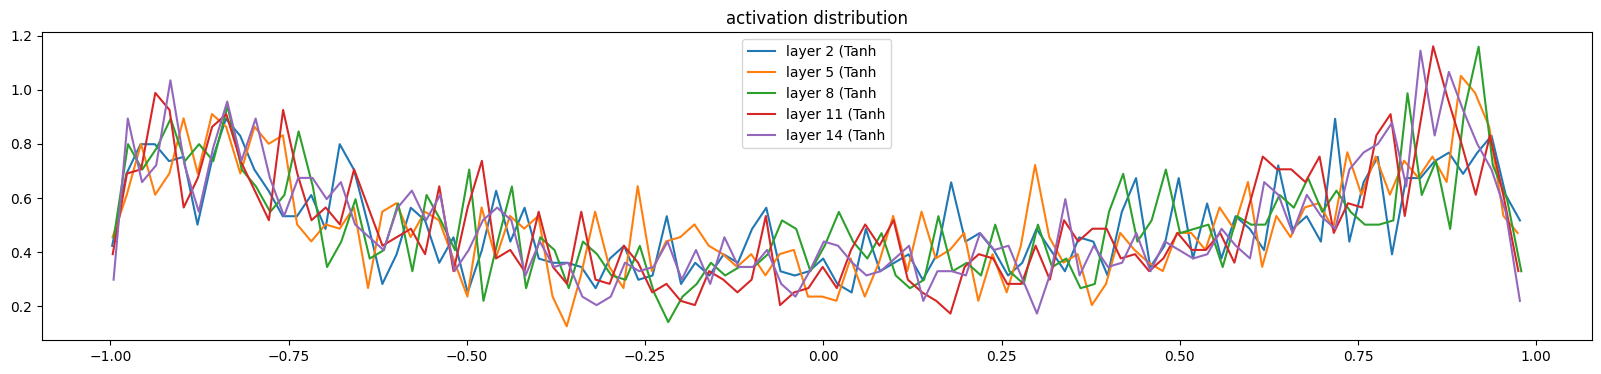

In [208]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' %
              (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')
# 5% is good saturation, ideally similar across layers, roughly gaussian to use most of tanh's dynamic range

layer 2 (      Tanh): mean -0.000000, std 2.985768e-03
layer 5 (      Tanh): mean +0.000000, std 2.543702e-03
layer 8 (      Tanh): mean +0.000000, std 2.470582e-03
layer 11 (      Tanh): mean +0.000000, std 2.311888e-03
layer 14 (      Tanh): mean +0.000000, std 2.358913e-03


Text(0.5, 1.0, 'gradient distribution')

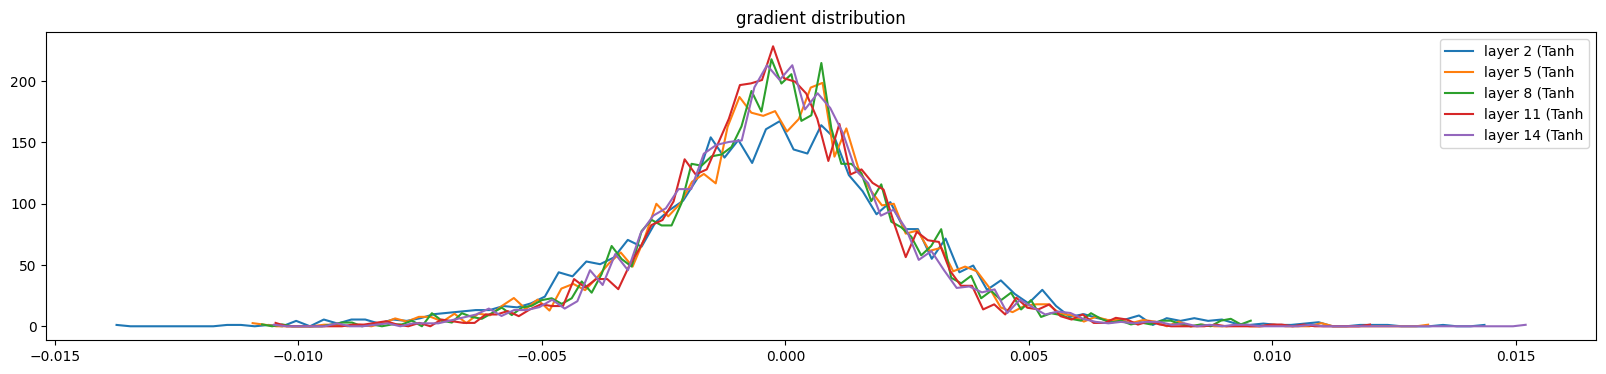

In [209]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]):  # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' %
              (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

## What we're looking for in the grads

That all the different layers in the sandwich have the same gradient. Nothing shrinking or exploding


weight   (27, 10) | mean -0.000000 | std 8.532061e-03 | grad:data ratio 8.523458e-03
weight  (30, 100) | mean +0.000056 | std 6.926511e-03 | grad:data ratio 2.216305e-02
weight (100, 100) | mean +0.000067 | std 5.648527e-03 | grad:data ratio 3.379711e-02
weight (100, 100) | mean -0.000042 | std 5.028825e-03 | grad:data ratio 2.982525e-02
weight (100, 100) | mean -0.000000 | std 4.746155e-03 | grad:data ratio 2.828118e-02
weight (100, 100) | mean -0.000004 | std 4.276121e-03 | grad:data ratio 2.547080e-02
weight  (100, 27) | mean +0.000019 | std 7.934636e-03 | grad:data ratio 4.761428e-02


Text(0.5, 1.0, 'weights gradient distribution')

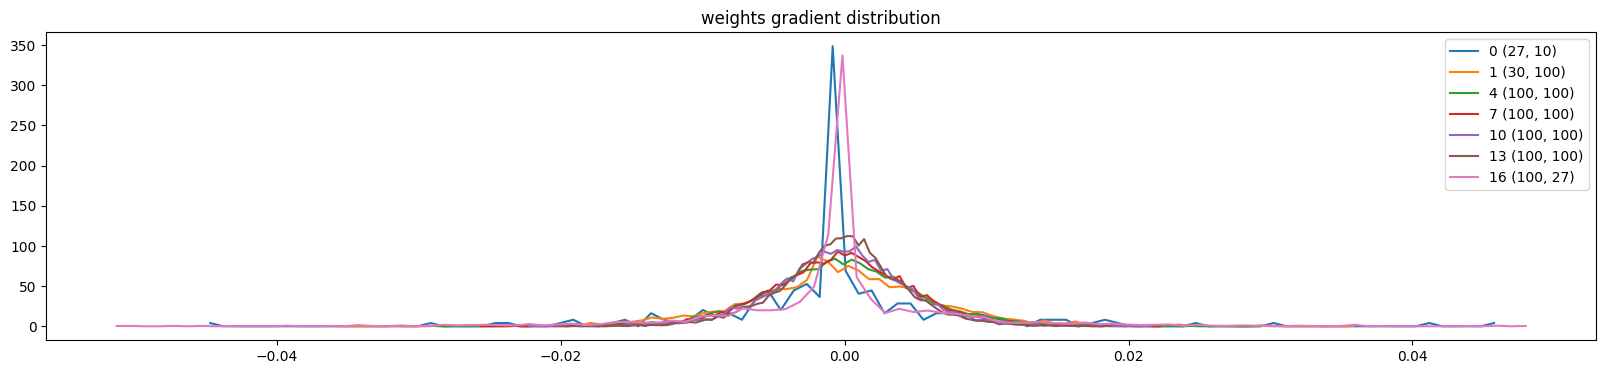

In [210]:
# visualize histograms
plt.figure(figsize=(20, 4))  # width and height of the plot
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' %
              (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

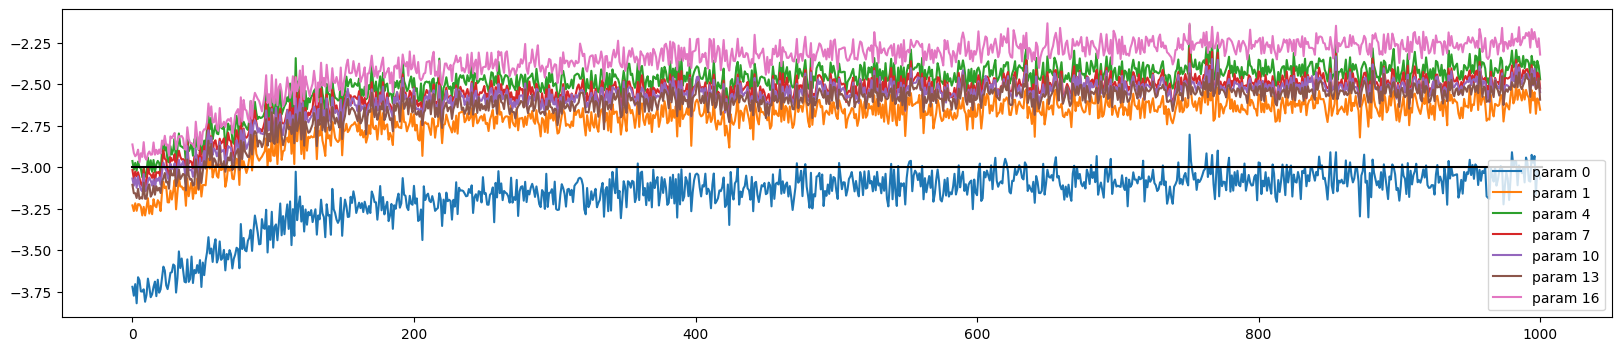

In [211]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
# these ratios should be ~1e-3, indicate on plot LOG SCALE
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

### Karpathy Notes

- Want to make sure updates are somewhere around but not too much above `1e-3` on (which is -3) on the log plot
- If it's below -3 it means params are not training fast enough (eg. low learning rate)


In [213]:
# Using pytorch nn instead -- equivalent api what a guy
from torch import nn

n_embd = 10  # the dimensionality of the character embedding vectors
n_hidden = 100  # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    # Standard place to put the BatchNorm layer is after linear, before nonlinear
    nn.Linear(n_embd * block_size, n_hidden,
              bias=False), nn.BatchNorm1d(n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(
        n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(
        n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(
        n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(
        n_hidden), nn.Tanh(),
    nn.Linear(n_hidden, vocab_size, bias=False), nn.BatchNorm1d(
        vocab_size),  # putting at end is also fine
]
# layers = [
#     Linear(n_embd * block_size, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1  # if batchnorm
    # layers[-1].weight *= 0.1 # if no batchnorm
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            # need this to fight the repeated squashing effect of successive tanh layers
            # a good setting for linear + tanh sandwiches
            layer.weight *= 5/3  # <- but so much work just to get this right = pencil balancing

# for every layer, and then for every parameter in each layer:
# all_params = []
# for layer in layers:
#     for p in layer.parameters():
#         all_params.append(p)
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [215]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)  # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        # Std dev of update / Std of actual data content
        # How great are the updates compared to tensors?
        # Then take log 10 so its nicer to visualize
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item()
                  for p in parameters])

    if i >= 1000:
        break  # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2574
